# Pseudo classification

Transform classification problem to regression via transformation from $\{negativeClass, positiveClass\} \Rightarrow \{-t, t\}$.

Tested methods:
- LinearRegression/LogisticRegression
- CatBoostRegressor/CatBoostClassifier
- RILSROLS - RILSROLSRegressor/RILSROLSBinaryClassifier
- HROCH - SymbolicRegressor/NonlinearLogisticRegressor
- HROCH - PseudoClassifier/NonlinearLogisticRegressor (PseudoClassifier use finetuning constants to LogLoss score)

In [1]:
import numpy as np, pandas as pd
from HROCH import NonlinearLogisticRegressor, SymbolicRegressor, PseudoClassifier
from rils_rols.rils_rols import RILSROLSBinaryClassifier, RILSROLSRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from pmlb import classification_dataset_names
from pmlb import fetch_data, classification_dataset_names

/home/jano/GECCO2023/SR/clf_test/classification_test/test_env/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


## GenericPseudoClassifier

Similar to PseudoClassifier from HROCH we define generic GenericPseudoClassifier class.
'estimator' parameter is a regressor instance and 't' parameter is a transformation parameter for transformation $\{negativeClass, positiveClass\} \Rightarrow \{-t, t\}$ Unlike PseudoClassifier from HROCH GenericPseudoClassifier don't finetune constants to LogLoss score.

In [2]:
from pseudo import GenericPseudoClassifier

## PseudoClassifier evaluation

In [3]:
from sklearn.metrics import log_loss
from sklearn.base import clone
def eval_method(clf, pseudo_clf, t_test, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    proba_clf_train, proba_clf_test = clf.predict_proba(X_train), clf.predict_proba(X_test)
    score_clf_train, score_clf_test = log_loss(y_train, proba_clf_train), log_loss(y_test, proba_clf_test)
    
    score_pseudo_train, score_pseudo_test = [], []
    for t in t_test:
        reg = clone(pseudo_clf)
        reg.t = t
        reg.fit(X_train, y_train)
        proba_train, proba_test = reg.predict_proba(X_train), reg.predict_proba(X_test)
        score_train, score_test = log_loss(y_train, proba_train), log_loss(y_test, proba_test)
        
        score_pseudo_train.append(score_train)
        score_pseudo_test.append(score_test)
        
    return score_clf_train, score_clf_test, score_pseudo_train, score_pseudo_test    
    

## Fetch data

In [4]:
%%time

test_suite = [
    'credit_g',
    'mofn_3_7_10',
    'dis', 
    'coil2000',
    ]

datasets = []
for test in test_suite:
    if not test in classification_dataset_names:
        print(f'unknown dataset name {test}')
        continue
    df = fetch_data(test, local_cache_dir='../instances/pmlb')
    datasets.append((test, df))
    

CPU times: user 56.4 ms, sys: 16.5 ms, total: 72.9 ms
Wall time: 72 ms


## Evaluate test suite

In [5]:
RANDOM_STATE = 123
TIME_LIMIT = 1

hroch_params = {
    'num_threads' : 1,
    'time_limit' : TIME_LIMIT,
    'iter_limit' : 0,
    'random_state' : RANDOM_STATE,
}

ps_params = {
    'n' : 8, # finetune 8 top models
    'regressor_params' : hroch_params,
}

rr_params = {
    'random_state' : RANDOM_STATE,
    'max_seconds' : TIME_LIMIT,
    'max_fit_calls' : 1000000000
}

cb_params = {
    'random_state' : RANDOM_STATE,
    'silent' : True
}

tested_methods = [
    ('LR', LogisticRegression(), GenericPseudoClassifier(LinearRegression())),
    ('CatBoost', CatBoostClassifier(**cb_params), GenericPseudoClassifier(CatBoostRegressor(**cb_params))),
    ('Rils-Rols', RILSROLSBinaryClassifier(**rr_params), GenericPseudoClassifier(RILSROLSRegressor(**rr_params))),    
    ('Hroch', NonlinearLogisticRegressor(**hroch_params), GenericPseudoClassifier(SymbolicRegressor(**hroch_params))),
    ('Hroch-finetuned', NonlinearLogisticRegressor(**hroch_params), PseudoClassifier(**ps_params)),
]

Calling with max_fit_calls=1000000000 max_seconds=1 complexity_penalty=0.001 max_complexity=50 sample_size=1 verbose=False random_state=123
Calling with max_fit_calls=1000000000 max_seconds=1 complexity_penalty=0.001 max_complexity=50 sample_size=1 verbose=False random_state=123


In [6]:
%%time

test = np.arange(start=-1.001, stop = 6.001, step = 1.0)

results = {}
clf_results = {}

for df_name, df in datasets:
    print(f'testing df {df_name}')
    X = df.drop('target', axis=1)
    y = df['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=RANDOM_STATE)

    results[df_name] = pd.DataFrame()
    results[df_name]['t'] = test
    
    clf_results[df_name] = {}
    
    for name, clf, reg in tested_methods:
        print(f'\tevaluating {name} method')
        score_clf_train, score_clf_test, score_pseudo_train, score_pseudo_test = eval_method(clf, reg, test, X_train, y_train, X_test, y_test)
        results[df_name]['score_train_'+name] = score_pseudo_train
        results[df_name]['score_test_'+name] = score_pseudo_test
        clf_results[df_name][name] = (score_clf_train, score_clf_test)  


testing df credit_g
	evaluating LR method
	evaluating CatBoost method
	evaluating Rils-Rols method
Calling with max_fit_calls=1000000000 max_seconds=1 complexity_penalty=0.001 max_complexity=50 sample_size=1 verbose=False random_state=123
Calling with max_fit_calls=1000000000 max_seconds=1 complexity_penalty=0.001 max_complexity=50 sample_size=1 verbose=False random_state=123
Calling with max_fit_calls=1000000000 max_seconds=1 complexity_penalty=0.001 max_complexity=50 sample_size=1 verbose=False random_state=123
Calling with max_fit_calls=1000000000 max_seconds=1 complexity_penalty=0.001 max_complexity=50 sample_size=1 verbose=False random_state=123
Calling with max_fit_calls=1000000000 max_seconds=1 complexity_penalty=0.001 max_complexity=50 sample_size=1 verbose=False random_state=123
Calling with max_fit_calls=1000000000 max_seconds=1 complexity_penalty=0.001 max_complexity=50 sample_size=1 verbose=False random_state=123
Calling with max_fit_calls=1000000000 max_seconds=1 complexit

In [7]:
import matplotlib.pyplot as plt

def plot_results(df_name):
    res_df = results[df_name]
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for ( name, _, _ ), c in zip(tested_methods, colors):
        plt.plot(res_df['t'], res_df['score_test_' + name], c, label= name + ' test')
        clf_score = clf_results[df_name][name][1]
        plt.plot(res_df['t'], [clf_score] * len(res_df), c + '--')

    plt.legend()
    plt.xlabel('t')
    plt.ylabel('LogLoss')
    plt.title('PseudoClassification' + ' ' + df_name)
    plt.grid(True)

    plt.show()

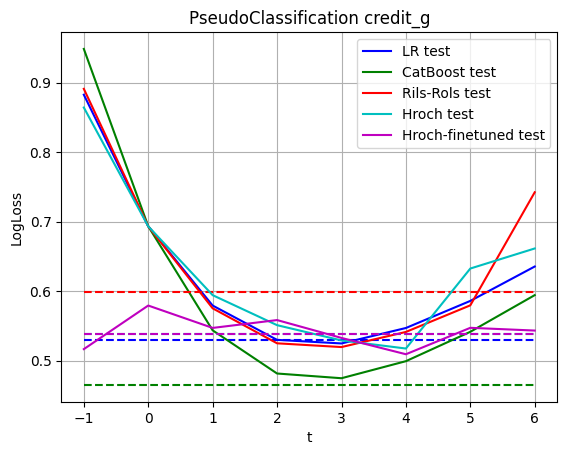

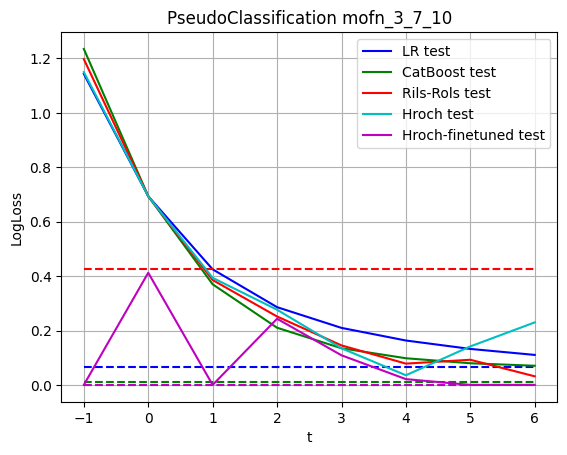

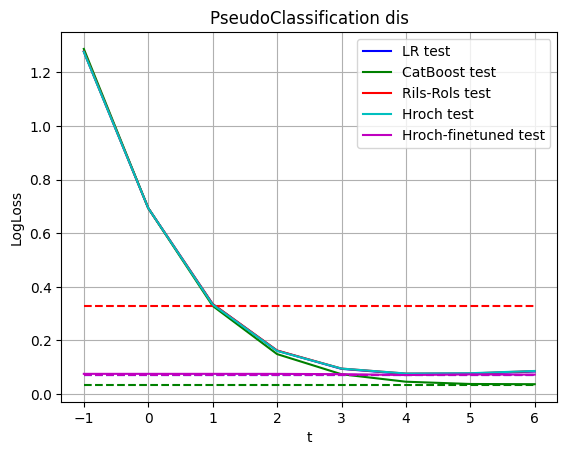

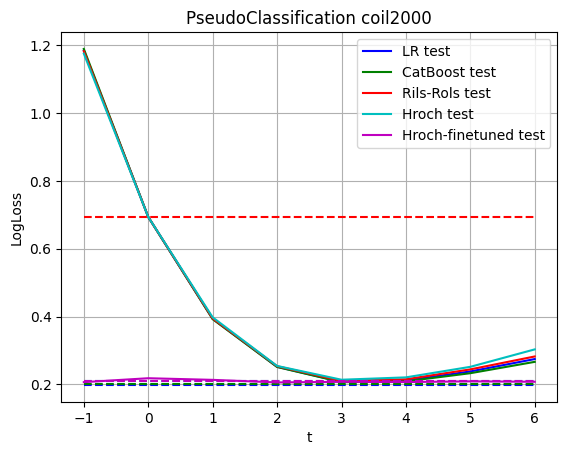

In [8]:
for df_name in test_suite:
    plot_results(df_name)